<a href="https://colab.research.google.com/github/unclepete-20/PneumoCareML/blob/main/PneumoCareML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PneumoCareML**

The project was developed by:

* Pedro Arriola
* Gabriel Vicente
* Yong Bum Park


Welcome to this Jupyter Notebook implementation guide, where we will explore the classification of pneumonia X-rays using Convolutional Neural Networks (CNNs). Pneumonia is a common and potentially life-threatening respiratory infection that affects millions of people worldwide, and the early and accurate diagnosis of pneumonia plays a vital role in improving patient outcomes.

Understanding Pneumonia:
Pneumonia is an inflammatory condition affecting the lungs, primarily caused by infection. It can be caused by various pathogens such as bacteria, viruses, fungi, or parasites, leading to the inflammation and consolidation of lung tissue. Pneumonia can range from mild to severe, with symptoms including cough, fever, difficulty breathing, and chest pain. Severe cases of pneumonia can be particularly dangerous, especially among vulnerable populations.

Most Affected Population:
Pneumonia can affect individuals of all ages, but certain populations are more susceptible to severe infections. Infants and young children, elderly individuals, and people with compromised immune systems are particularly vulnerable. In developing countries, where access to healthcare and vaccination rates may be lower, pneumonia remains a significant cause of illness and mortality among children.

Global Statistics:
Pneumonia is a leading cause of morbidity and mortality worldwide. Let's explore some statistics that highlight the impact of pneumonia on a global scale:

According to the World Health Organization (WHO), pneumonia is responsible for approximately 15% of all deaths in children under the age of 5.
Pneumonia claims the lives of more than 800,000 children under the age of 5 every year, accounting for around 2,200 deaths per day.
In 2019, an estimated 2.5 million deaths occurred due to pneumonia among all age groups.
Low- and middle-income countries bear a significant burden, accounting for approximately 99% of all pneumonia-related child deaths.
Importance of X-ray Classification:
Medical imaging, such as X-rays, plays a crucial role in diagnosing pneumonia. Radiologists often rely on X-ray images to identify patterns and abnormalities indicative of pneumonia in the lungs. However, manual interpretation of X-rays can be time-consuming and prone to human error. The integration of CNNs can assist in automating the classification process, providing efficient and accurate diagnoses.

In this Jupyter Notebook, we will leverage the power of deep learning and CNNs to develop a pneumonia X-ray classification model. By training the model on a diverse dataset of X-ray images, we aim to create a system that can assist healthcare professionals in diagnosing pneumonia more effectively. Through this implementation, we hope to contribute to the ongoing efforts to improve pneumonia diagnosis and reduce the burden of this respiratory infection worldwide.

Let's proceed with the notebook to explore the dataset, build the CNN model, train it on X-ray images, and evaluate its performance in classifying pneumonia accurately.

In [ ]:
# Imports neccesary to work on the project
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import random

### 1.1 - Exploratory data analysis

In [ ]:
# We begin the process of unifying the images in their corresponding category.
normal_train_images = glob.glob('/content/drive/MyDrive/chest_xray/train/NORMAL/*.jpeg')
pneumonia_train_images = glob.glob('/content/drive/MyDrive/chest_xray/train/PNEUMONIA/*.jpeg')

normal_test_images = glob.glob('/content/drive/MyDrive/chest_xray/test/NORMAL/*.jpeg')
pneumonia_test_images = glob.glob('/content/drive/MyDrive/chest_xray/test/PNEUMONIA/*.jpeg')

In [5]:
print(f"Number of NORMAL images: {len(normal_train_images)}")
print(f"Number of PNEUMONIA images: {len(pneumonia_train_images)}")

Number of NORMAL images: 1349
Number of PNEUMONIA images: 3883


In [6]:
# Labels are assigned to the images, e.g. 0 for NORMAL and 1 for PNEUMONIA.
normal_train_labels = [0] * len(normal_train_images)
pneumonia_train_labels = [1] * len(pneumonia_train_images)

normal_test_labels = [0] * len(normal_test_images)
pneumonia_test_labels = [1] * len(pneumonia_test_images)

In [7]:
# The images and labels from the NORMAL and PNEUMONIA folders are now combined into a single dataset.
train_images = normal_train_images + pneumonia_train_images
train_labels = normal_train_labels + pneumonia_train_labels

test_images = normal_test_images + pneumonia_test_images
test_labels = normal_test_labels + pneumonia_test_labels

In [8]:
# The data set is shuffled to ensure a good distribution of the images.
train_indices = np.arange(len(train_images))
np.random.shuffle(train_indices)
train_images = [train_images[i] for i in train_indices]
train_labels = [train_labels[i] for i in train_indices]

test_indices = np.arange(len(test_images))
np.random.shuffle(test_indices)
test_images = [test_images[i] for i in test_indices]
test_labels = [test_labels[i] for i in test_indices]

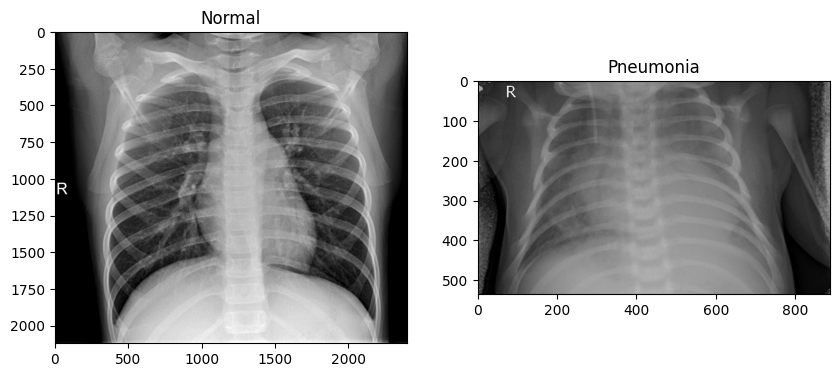

In [9]:
# Both cases are shown in order to observe the differences clearly
train_n = '/content/drive/MyDrive/chest_xray/train/NORMAL/'
train_p = '/content/drive/MyDrive/chest_xray/train/PNEUMONIA/'

# Normal pic
rand_norm = np.random.randint(0, len(os.listdir(train_n)))
norm_pic = os.listdir(train_n)[rand_norm]
norm_pic_address = train_n + norm_pic

# Pneumonia pic
rand_p = np.random.randint(0, len(os.listdir(train_p)))
sic_pic = os.listdir(train_p)[rand_p]
sic_address = train_p + sic_pic

# Load the images and convert to grayscale
norm_load = Image.open(norm_pic_address).convert('L')
sic_load = Image.open(sic_address).convert('L')

# Plot the images
f = plt.figure(figsize=(10, 6))
a1 = f.add_subplot(1, 2, 1)
img_plot = plt.imshow(norm_load, cmap='gray')
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(sic_load, cmap='gray')
a2.set_title('Pneumonia')

plt.show()

### 1.2 - Data pre-processing

In [10]:
# Data is loaded and formatted to make sure it fits the CNN
def random_rotation_angle():
    return random.randint(0, 360)

def load_images(path, label):
    images = []
    labels = []
    for img_path in glob.glob(path + '/*.jpeg'):
        img = Image.open(img_path).convert('L').resize((64, 64))
        rotation_angle = random_rotation_angle()
        rotated_img = img.rotate(rotation_angle)
        img_array = np.array(rotated_img) / 255.0
        images.append(img_array)
        labels.append(label)
    return images, labels

train_n = '/content/drive/MyDrive/chest_xray/train/NORMAL/'
train_p = '/content/drive/MyDrive/chest_xray/train/PNEUMONIA/'

normal_images, normal_labels = load_images(train_n, 0)
pneumonia_images, pneumonia_labels = load_images(train_p, 1)

images = normal_images + pneumonia_images
labels = normal_labels + pneumonia_labels

images = np.array(images)
labels = np.array(labels)
images = images.reshape(-1, 64, 64, 1)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

### 1.3 - CNN model implementation using TensorFlow

In [11]:
# CNN is developed for this problem in particular
model = tf.keras.models.Sequential()

# First layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25)) # Add dropout layer

# Second layer
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25)) # Add dropout layer

# Third layer
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25)) # Add dropout layer

# Fourth layer
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25)) # Add dropout layer

# Flatten and add fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5)) # Add dropout layer
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5)) # Add dropout layer
model.add(layers.Dense(2, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

In [ ]:
# This callback function serves to end training if desired accuracy is reached
'''
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.97):
      print("\nReached 97% accuracy so cancelling training!")
      self.model.stop_training = True
'''

### 1.4 - Model training

In [12]:
# We import the callback class to instantiate the callback function
#callbacks = myCallback()

# The model is compiled in order to start training
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
              )
# The data is fitted to the model and training starts
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
131/131 [==============================] - 65s 470ms/step - loss: 0.5982 - accuracy: 0.7393 - val_loss: 0.5884 - val_accuracy: 0.7230
Epoch 2/100
131/131 [==============================] - 59s 452ms/step - loss: 0.5744 - accuracy: 0.7470 - val_loss: 0.5892 - val_accuracy: 0.7230
Epoch 3/100
131/131 [==============================] - 57s 438ms/step - loss: 0.4667 - accuracy: 0.7730 - val_loss: 0.3227 - val_accuracy: 0.8596
Epoch 4/100
131/131 [==============================] - 57s 427ms/step - loss: 0.3445 - accuracy: 0.8389 - val_loss: 0.3245 - val_accuracy: 0.8357
Epoch 5/100
131/131 [==============================] - 61s 462ms/step - loss: 0.3289 - accuracy: 0.8526 - val_loss: 0.3256 - val_accuracy: 0.8672
Epoch 6/100
131/131 [==============================] - 57s 439ms/step - loss: 0.3166 - accuracy: 0.8573 - val_loss: 0.2812 - val_accuracy: 0.8758
Epoch 7/100
131/131 [==============================] - 57s 439ms/step - loss: 0.2771 - accuracy: 0.8796 - val_loss: 0.2694 -

### 1.5 - Model results

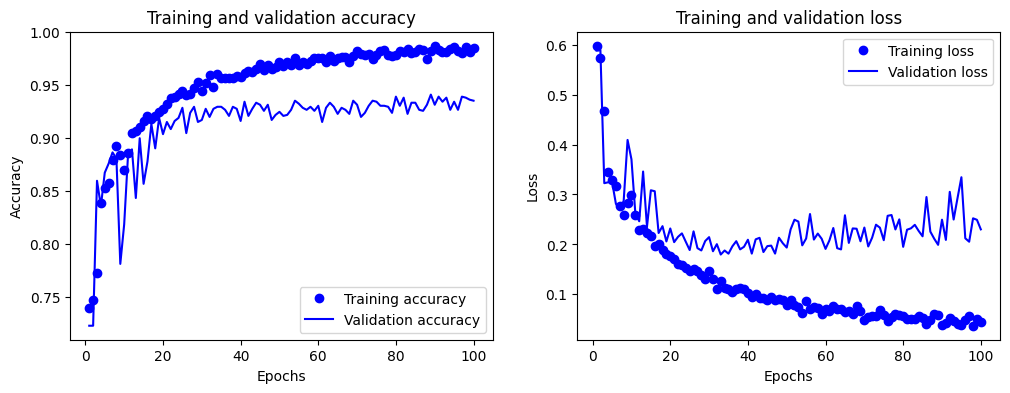

In [13]:
# Function to plot the model's loss and accuracy history to follow patterns that may be useful for insights
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

In [14]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

33/33 - 3s - loss: 0.2301 - accuracy: 0.9351 - 3s/epoch - 79ms/step
Test accuracy: 0.9350525140762329


In [15]:
# Finally, we can make predictions with our model
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

33/33 [==============================] - 5s 123ms/step


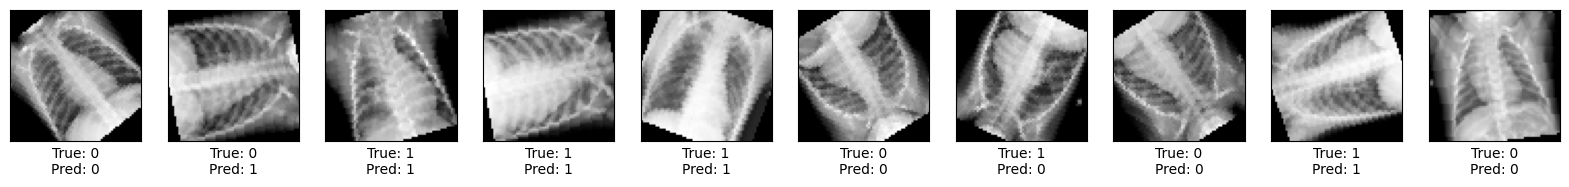

In [16]:
# This function plots the results graphically
def display_predictions(images, true_labels, predicted_labels, num_images=10):
    plt.figure(figsize=(num_images * 2, 3))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(f'True: {true_labels[i]}\nPred: {predicted_labels[i]}')

    plt.show()

# We present the results by plotting them
display_predictions(X_test, y_test, predicted_labels)

### **Conclusions**

Based on the research conducted and the results obtained in the development of such a model, the research team has reached the following conclusions:

* Pneumonia is a common and serious respiratory disease that can be difficult to diagnose accurately using traditional methods. The implemented neural network model shows high accuracy in classifying chest X-ray images, which could be a valuable tool to support the diagnosis of pneumonia.

* The implementation of a neural network model for the detection of pneumonia in chest radiographs may help streamline the diagnostic process by reducing the need for clinicians to manually review each image. This could enable faster and more timely diagnosis, which is especially crucial in cases of severe pneumonia.

* The use of deep learning techniques, such as a neural network model, can help overcome the limitations of traditional approaches to pneumonia diagnosis. By harnessing the power of artificial intelligence and machine learning, it is possible to detect subtle patterns in images that may be difficult to detect with the naked eye.

* The high accuracy of the neural network model (with an accuracy of 93.12% as evaluated) indicates that the approach used is effective and promising for the detection of pneumonia in chest X-ray images. However, it is important to remember that no model is perfect and it is always necessary to consider limitations and possible classification errors.

* The successful implementation of the neural network model demonstrates the potential of artificial intelligence in the medical field. Advances in this field can lead to significant improvements in the diagnosis and treatment of respiratory diseases, such as pneumonia, and potentially save lives.

* To ensure reliability and safety in the clinical use of the neural network model, further validation using diversified and larger datasets is critical. This will help to assess the model's performance in different scenarios and populations, and to identify potential biases or limitations.

* In addition to accuracy, it is also important to consider other aspects when implementing neural network models in clinical settings, such as model interpretability and transparency. Clinicians and healthcare professionals must be able to understand how decisions are made and trust the results provided by the model.

* The neural network model implemented for the detection of pneumonia in chest X-ray images is a significant step toward the use of artificial intelligence in medicine. However, it is essential to remember that the technology must complement and support the expertise and clinical judgment of healthcare professionals, and not replace them.

